In [1]:
import rascaline
rascaline._c_lib._get_library()

from copy import deepcopy

import numpy as np

from equisolve.numpy.scripts import MultiSpectraScript
from equisolve.numpy.models.linear_model import Ridge
from equisolve.numpy.preprocessing import StandardScaler
from equisolve.utils.convert import ase_to_tensormap
from equisolve.utils.split_data import split_data
from equisolve.utils.metrics import rmse, rmspe

import equistore

import ase.io


In [2]:
import matplotlib.pyplot as plt

In [3]:
frames = ase.io.read("water_converted.extxyz", ":15") # CHANGE TO YOUR DATASET
# it would be better for a well defined training behaviour if you use 2k frames
# but that might bring you to the RAM limit of your computer, depending on the number
# of atoms in each frame
y = ase_to_tensormap(frames, energy="TotEnergy", forces="force")

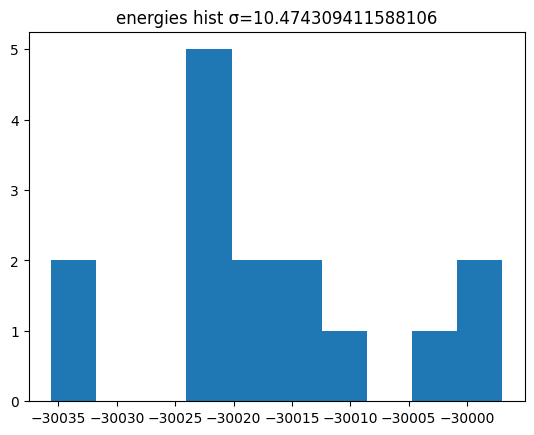

In [4]:
plt.hist(y[0].values)
plt.title(f'energies hist σ={np.std(y[0].values)}')
plt.show()
plt.close()

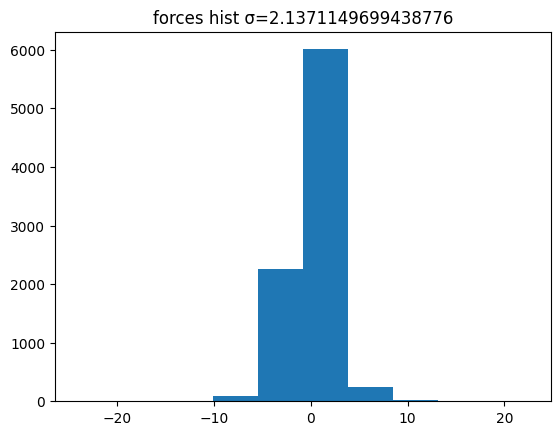

In [9]:
plt.hist(y[0].gradient('positions').data.flatten())
plt.title(f"forces hist σ={np.std(y[0].gradient('positions').data.flatten())}")
plt.show()
plt.close()

In [6]:
HYPERS = {
    "cutoff": 5.0,
    "max_radial": 8,
    "max_angular": 6,
    "atomic_gaussian_width": 0.25,
    "center_atom_weight": 1.0,
    "radial_basis":{"Gto": {"spline_accuracy": 1e-5}},
    "cutoff_function": {"ShiftedCosine": {"width": 0.2}},
    "radial_scaling": {"Willatt2018": {"exponent": 6, "rate": 3, "scale": 2.0}},
}

multi_spectra_hypers = {}
multi_spectra_hypers['Composition'] = {'per_structure': False}
multi_spectra_hypers['SoapRadialSpectrum'] = deepcopy(HYPERS)
multi_spectra_hypers['SoapRadialSpectrum'].pop('max_angular')
multi_spectra_hypers['SoapPowerSpectrum'] = deepcopy(HYPERS)

transformer = StandardScaler(parameter_keys=["values"])
estimator = Ridge(parameter_keys=["values", "positions"])
script = MultiSpectraScript(multi_spectra_hypers,
                            transformer_y=transformer,
                            estimator=estimator)


In [7]:
Xi = script.compute(systems=frames, gradients=["positions"])

### training

In [8]:
Xi_train, Xi_val, Xi_test = {}, {}, {}
for key in Xi.keys():
    Xi_train[key], Xi_val[key], Xi_test[key] = split_data(Xi[key], axis='samples', names=['structure'], n_groups=3, seed=5)[0][0]
                                                           
y_train, y_val, y_test = split_data(y, axis='samples', names=['structure'], n_groups=3, seed=5)[0][0]

In [10]:
script.fit(Xi_train, y_train, **{"estimator": {"alpha": 1e-12}})

In [10]:
print("train energy RMSE", script.score(Xi_train, y_train, parameter_keys=['values']))
print("train forces RMSE", script.score(Xi_train, y_train, parameter_keys=['positions']))

print("test energy RMSE", script.score(Xi_test, y_test, parameter_keys=['values']))
print("test forces RMSE", script.score(Xi_test, y_test, parameter_keys=['positions']))

train energy RMSE 5.327158832694204
train forces RMSE 0.1453119534933828
test energy RMSE 12.54145677502653
test forces RMSE 0.24002168287180847


It is overfitting (low train and high test error), seems reasonable for such small alpha

### PCA

In [11]:
X = script.compute_features(Xi) # script needs to be fitted, because it contains transformers

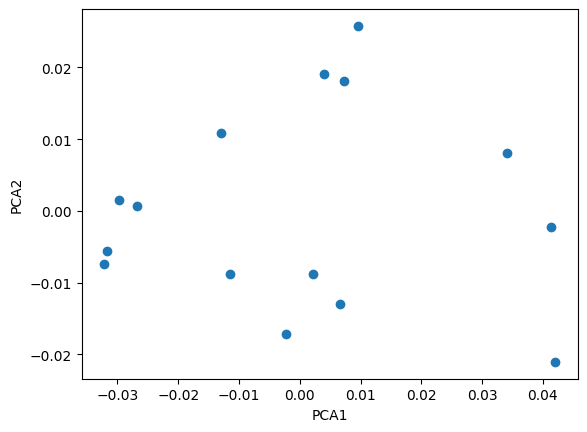

In [23]:
from sklearn.decomposition import PCA
Xt = PCA(n_components=2).fit_transform(X[0].values)
plt.scatter(Xt[:, 0], Xt[:, 1])
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()
plt.close()

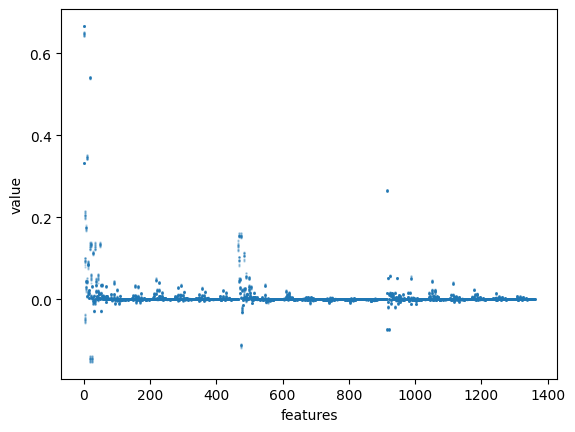

In [37]:
for i in range(X[0].values.shape[1]):
    plt.scatter(np.ones(X[0].values[:, i].shape[0])*i, X[0].values[:, i], alpha=0.25, color='C0', s=0.5)
plt.xlabel('features')
plt.ylabel('value')
plt.show()
plt.close()

### 2-fold cross-validation

In [35]:
def compute_sample_weights(y, energy=1.0, forces=1.0):
    sw = equistore.ones_like(y)
    sw[0].values[:] *= energy
    sw[0].gradient('positions').data[:] *= forces
    return sw

In [41]:
# I usually use a range of, but with this multispectra, this seems to be a better range
#alphas = np.geomspace(1e-12, 1e-3, 10)
# but because the dataset is extremely small, one has go to higher regularizers
alphas = np.geomspace(1e-12, 1e+4, 5)
 
energy_weights = np.linspace(0,1,5)


train_energy_rmse = {}
train_forces_rmse = {}

val_energy_rmse = {}
val_forces_rmse = {}


for energy_weight in energy_weights:
    sw = compute_sample_weights(y_train, energy=energy_weight)
    for alpha in alphas:
        print(f"Computing errors for alpha={alpha}, energy_weight={energy_weight}")
        script.fit(Xi_train, y_train, **{"estimator": {"alpha": float(alpha), "sample_weight": sw}})
        y_train_pred = script.forward(Xi_train)
        y_val_pred = script.forward(Xi_val)

        train_energy_rmse[(alpha,energy_weight)] = rmse(y_train, y_train_pred, parameter_key='values')
        train_forces_rmse[(alpha,energy_weight)] = rmse(y_train, y_train_pred, parameter_key='positions')

        val_energy_rmse[(alpha,energy_weight)] = rmse(y_val, y_val_pred, parameter_key='values')
        val_forces_rmse[(alpha,energy_weight)] = rmse(y_val, y_val_pred, parameter_key='positions')


Computing errors for alpha=1e-12, energy_weight=0.0
Computing errors for alpha=1e-08, energy_weight=0.0
Computing errors for alpha=0.0001, energy_weight=0.0
Computing errors for alpha=1.0, energy_weight=0.0
Computing errors for alpha=10000.0, energy_weight=0.0
Computing errors for alpha=1e-12, energy_weight=0.25
Computing errors for alpha=1e-08, energy_weight=0.25
Computing errors for alpha=0.0001, energy_weight=0.25
Computing errors for alpha=1.0, energy_weight=0.25
Computing errors for alpha=10000.0, energy_weight=0.25
Computing errors for alpha=1e-12, energy_weight=0.5
Computing errors for alpha=1e-08, energy_weight=0.5
Computing errors for alpha=0.0001, energy_weight=0.5
Computing errors for alpha=1.0, energy_weight=0.5
Computing errors for alpha=10000.0, energy_weight=0.5
Computing errors for alpha=1e-12, energy_weight=0.75
Computing errors for alpha=1e-08, energy_weight=0.75
Computing errors for alpha=0.0001, energy_weight=0.75
Computing errors for alpha=1.0, energy_weight=0.75
C

In [ ]:
def alpha_weighting(x):
    return 1 / (1 + np.exp(-x))


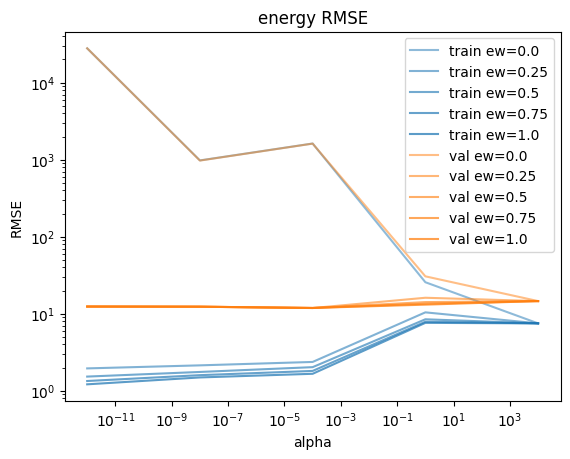

In [43]:
plt.title('energy RMSE')
for energy_weight in energy_weights:
    plt.loglog(alphas, [train_energy_rmse[(alpha, energy_weight)] for alpha in alphas],
               color='C0', label=f'train ew={energy_weight}', alpha=alpha_weighting(energy_weight))
for energy_weight in energy_weights:

    plt.loglog(alphas, [val_energy_rmse[(alpha, energy_weight)] for alpha in alphas],
               color='C1', label=f'val ew={energy_weight}', alpha=alpha_weighting(energy_weight))
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.legend()
plt.show()
plt.close()

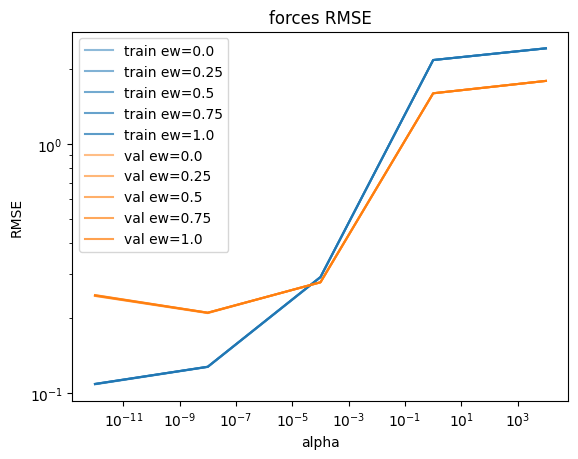

In [44]:
plt.title('forces RMSE')
for energy_weight in energy_weights:
    plt.loglog(alphas, [train_forces_rmse[(alpha, energy_weight)] for alpha in alphas],
               color='C0', label=f'train ew={energy_weight}', alpha=alpha_weighting(energy_weight))
for energy_weight in energy_weights:

    plt.loglog(alphas, [val_forces_rmse[(alpha, energy_weight)] for alpha in alphas],
               color='C1', label=f'val ew={energy_weight}', alpha=alpha_weighting(energy_weight))
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.legend()
plt.show()
plt.close()

I think you don't see and effect on the forces, because we just train on 5 frames (5 energies) while having almost 2k features. Training on energy and forces does not limit the model and thus does not restrict the fitting of the forces.

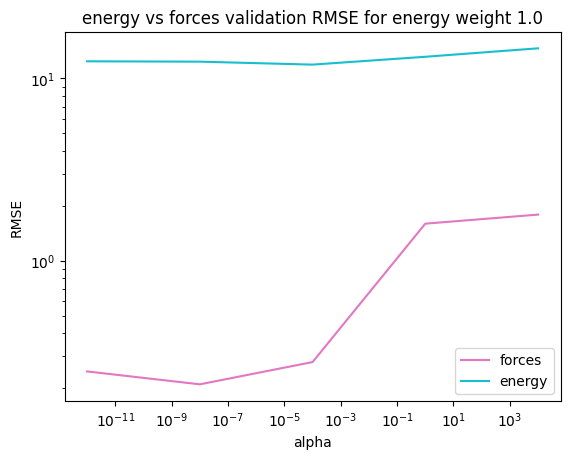

In [49]:
plt.title('energy vs forces validation RMSE for energy weight 1.0')
plt.loglog(alphas, [val_forces_rmse[(alpha, 1.0)] for alpha in alphas],
           color='C6', label='forces')
plt.loglog(alphas, [val_energy_rmse[(alpha, 1.0)] for alpha in alphas],
           color='C9', label='energy')
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.legend()
plt.show()
plt.close()

Choose one alpha that suits your force error and retrain on train+val.

In [30]:
Xi_retrain = {}
for key in Xi_train.keys():
    Xi_retrain[key] = equistore.join([Xi_train[key], Xi_val[key]], axis="samples")
y_retrain = equistore.join([y_train, y_val], axis="samples")


In [ ]:
script.fit(Xi_retrain, y_retrain, **{"estimator": {"alpha": 1e-8}})
y_test_pred = script.forward(Xi_test)
print("RMSE energies", rmse(y_test, y_test_pred, parameter_key='values'))
print("RMSE forces", rmse(y_test, y_test_pred, parameter_key='positions'))


In [7]:
import pickle
with open("multi_spectra_script-thorben.pickle", "wb") as file:
    pickle.dump(script, file)

### Testing i-pi support

In [8]:
import pickle
with open("multi_spectra_script-thorben.pickle", "rb") as file:
    script = pickle.load(file)

In [9]:
# in ipi

import ase.io
import numpy as np

structure = ase.io.read("h5o2+.extxyz", "0")

Xi = script.compute(systems=structure, gradients=["positions"])
y_pred = script.forward(Xi) # implicitely done in score function
energy = y_pred.block().values[0][0]
forces = np.array(y_pred.block().gradient("positions").data.reshape(-1, 3))

print(energy)
print()
print(forces)

-30021.592706684605

[[-3.49000829 -0.66491428  0.03825963]
 [ 3.31762319  0.70152297  1.06043758]
 [-0.53010739 -0.29730224 -0.87017826]
 [ 0.06258619 -0.01292945 -0.39877504]
 [ 0.5565406  -0.76222816  0.55000543]
 [ 0.77346134  0.24635373 -0.68418884]
 [-0.69009565  0.78949744  0.30443949]]


In [ ]:
# install ipi from this fork and branch https://github.com/agoscinski/i-pi/tree/equihack
# pip install pip install git+https://github.com/agoscinski/i-pi/@equihack

In [11]:
from equisolve.numpy.scripts import GenericMDCalculator

from ipi.utils.mathtools import det_ut3x3
from ipi.utils.units import unit_to_internal, unit_to_user


md_calc = GenericMDCalculator("multi_spectra_script-thorben.pickle",
                    is_periodic=True,
                    structure_template="h5o2+.extxyz",
                    atomic_numbers=[1,8])

In [ ]:
# If it runs through you can go to i-pi side and follow the instruction here
# https://github.com/agoscinski/i-pi/tree/equihack/examples/equiscript
# using the multi_spectra_script-thorben.pickle